In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import geopandas as gpd
import os
import cmocean.cm as cmo
import rasterio
import rasterio.plot as rplt
import app
import string
from affine import Affine
from rasterio.io import MemoryFile
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# 0. Import

In [2]:
data_folder = r"D:\[Code]\HydrofractureShackleton_2023\data"
data_dmg_folder = r"D:\[Code]\HydrofractureShackleton_2023\data-dmg"
data_img_folder = r"D:\[Code]\HydrofractureShackleton_2023\data-img"
figure_folder = r"D:\[Code]\HydrofractureShackleton_2023\figures"

In [3]:
path = os.path.join(data_folder, r"shackleton_hydrofractures.xlsx")
events_raw = pd.read_excel(path, index_col=0)
events_raw["geometry"] = gpd.GeoSeries.from_wkt(events_raw["geometry"])
events = gpd.GeoDataFrame(events_raw, geometry="geometry")  # type: ignore
events.set_crs("EPSG:4326", inplace=True)
events.sort_values("lon", inplace=True)
events.reset_index(drop=True, inplace=True)
events.to_crs("EPSG:3031", inplace=True)
events["label"] = list(string.ascii_uppercase)[: len(events)]
events["summer"] = [app.determine_antarctic_summer(d) for d in events["date-0 vis"]]
events["volume-1 m^3"] = np.nan_to_num(x=events["volume-1 m^3"].values, nan=0)  # type: ignore

In [ ]:
optical_files = [
    f
    for f in os.listdir(data_img_folder)
    if f.endswith(".tif") and f.split("_")[0] == "Optical"
]
sar_files = [
    f
    for f in os.listdir(data_img_folder)
    if f.endswith(".tif") and f.split("_")[0] == "Draining"
]

In [4]:
years = ["2018", "2019", "2020"]
xmin = 2.50e6
xmax = 2.76e6
ymax = -0.14e6
ymin = -0.60e6

In [5]:
coastline_folder = r"greene2022_coastlines"
all_coastline_files = os.listdir(coastline_folder)
coastlines = [
    gpd.read_file(os.path.join(coastline_folder, f)).cx[xmin:xmax, ymin:ymax]
    for f in all_coastline_files
    if f.endswith(".shp") and any([s in f for s in years])
]

In [6]:
buffer = 6e3
coastlines_buffer = [c.buffer(buffer) for c in coastlines]

In [7]:
iceshelves_folder = r"greene2022_iceshelves"
all_iceshelves_files = os.listdir(iceshelves_folder)
iceshelves = [
    gpd.read_file(os.path.join(iceshelves_folder, f)).cx[xmin:xmax, ymin:ymax]
    for f in all_iceshelves_files
    if f.endswith(".shp") and any([s in f for s in years])
]
ice_buffer = 150
for ice in iceshelves:
    ice.geometry = ice.buffer(ice_buffer)
    ice = ice.dissolve()
    ice.geometry = ice.buffer(-ice_buffer)
cmap = mpl.colormaps["cmo.ice"]
ice_colors = cmap(np.linspace(0.2, 0.8, 3))

In [56]:
lakes = gpd.read_file(os.path.join(data_folder, r"L8S2_20191201_20200331_lakeextent.shp"))
lakes.geometry = lakes.buffer(50)

In [57]:
grid_path = os.path.join(data_folder, r"ne_110m_graticules_1.shp")
grid = gpd.read_file(grid_path)  # https://www.naturalearthdata.com/about/terms-of-use/
grid.to_crs("EPSG:3031", inplace=True)
grid = grid.cx[xmin:xmax, ymin:ymax]
grid.head()

,degrees,direction,display,scalerank,dd,geometry
154,65,S,65 S,6,-65,"LINESTRING (-0.000 -2758494.765, 161.696 -2758..."
155,66,S,66 S,6,-66,"LINESTRING (2.365 -2644909.451, 155.038 -26449..."
156,67,S,67 S,6,-67,"LINESTRING (2.264 -2531747.008, 148.404 -25317..."
256,103,E,103 E,6,103,"LINESTRING (7.141 -1.648, 52938.639 -12219.281..."
257,102,E,102 E,6,102,"LINESTRING (7.169 -1.523, 53143.830 -11293.522..."


In [58]:
add = gpd.read_file(
    os.path.join(data_folder, r"add_coastline_high_res_line_v7_6.shp")
)
add.columns
add["surface"].unique()

shelf_lines = add[add["surface"].isin(["ice shelf and front"])]
grounding_lines = add[
    add["surface"].isin(
        [
            "ice coastline",
            "grounding line",
            "ice rumples",
            "rock against ice shelf",
            "rock coastline",
        ]
    )
]

shelf = shelf_lines.cx[xmin:xmax, ymin:ymax]
grounding_line = grounding_lines.cx[xmin:xmax, ymin:ymax]

0.17742295563220978
0.20046429336071014
0.18935947120189667


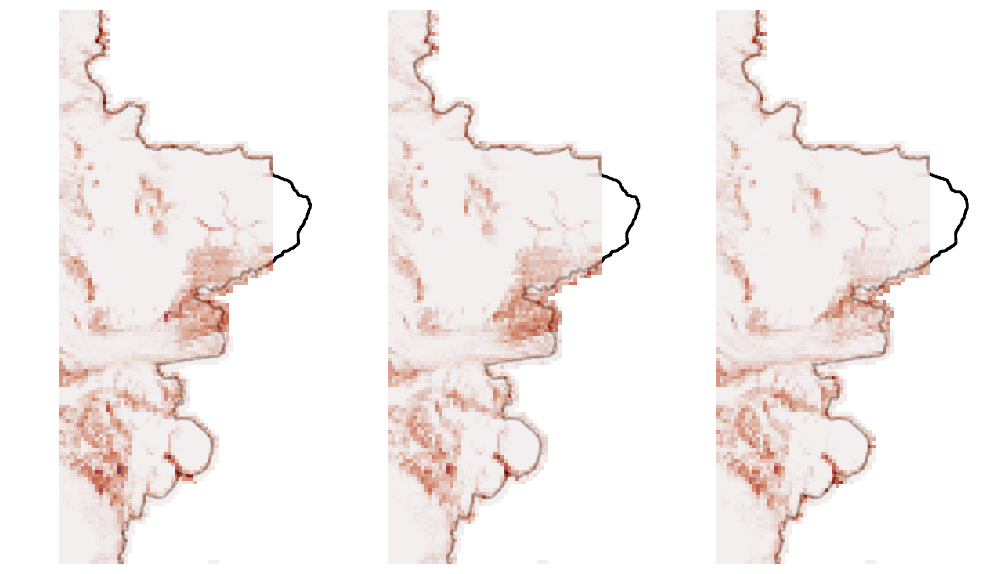

In [59]:
dmg_path = r"data-dmg"
delta_files = [
    "2018_S1_30m_delta-alpha.tif",
    "2019_S1_30m_delta-alpha.tif",
    "2020_S1_30m_delta-alpha.tif"]
dmg_files = [
    "2018_S1_30m_dmg.tif",
    "2019_S1_30m_dmg.tif",
    "2020_S1_30m_dmg.tif",
]
target_res = 3e3

dmg_outputs = []
dmg_transforms = []
fig, axes = plt.subplots(1, 3, figsize = (10, 20))
for i, f in enumerate(dmg_files):
    raster, transform = app.geotiffs.open_resampled(
        os.path.join(dmg_path, f), target_res, mode = "average"
    )
    masked, masked_transform = app.geotiffs.mask_dataset(
        raster,
        transform,
        coastlines_buffer[i],
        mode = "shape",
        filled = False)
    masked = masked / 0.5

    #masked[masked <= 0.001] = np.nan
    #masked = masked / np.nanmax(masked)
    print(np.nanmax(masked))
    ax = axes.ravel()[i]
    rplt.show(masked, ax=ax, transform=masked_transform, cmap="cmo.amp", alpha=0.8)
    coastlines[i].exterior.plot(ax=ax, color = "black", linewidth = 2, zorder = -5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    dmg_outputs.append(masked)
    dmg_transforms.append(masked_transform)
plt.tight_layout()
plt.show()

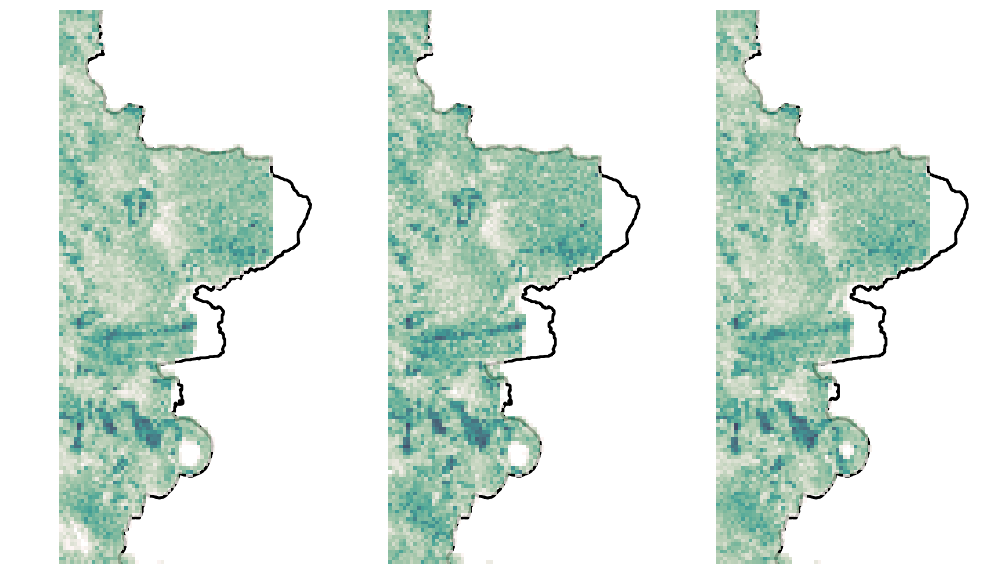

In [60]:
dmg_path = r"data-dmg"
delta_files = [
    "2018_S1_30m_delta-alpha.tif",
    "2019_S1_30m_delta-alpha.tif",
    "2020_S1_30m_delta-alpha.tif",
]

active_outputs = []
active_transforms = []

target_res = 3e3
fig, axes = plt.subplots(1, 3, figsize=(10, 20))
for i, f in enumerate(delta_files):
    raster, transform, meta = app.geotiffs.open(
        os.path.join(dmg_path, f)
    )

    activeness = app.geotiffs.create_active_crevasses_mask(raster, 45, 15)
    activeness_mask = np.zeros(activeness.shape) * 0
    activeness_mask[np.isfinite(activeness)] = 1
    resampled, resampled_transform = app.geotiffs.resample_dataset(
        activeness_mask, transform, target_res, mode="average"
    )
    resampled[resampled == 0] = np.nan
    #
    # print(np.nanmax(resampled), np.nanmin(resampled))
    # resampled[resampled <= 0.005] = np.nan

    ax = axes.ravel()[i]
    rplt.show(
        resampled, ax=ax, transform=resampled_transform, cmap="cmo.tempo", alpha=0.8
    )
    coastlines[i].exterior.plot(ax=ax, color="black", linewidth=2, zorder=-5)
    ax.set_xlim(transform.c, transform.c + raster.shape[-1] * transform.a)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    active_outputs.append(resampled)
    active_transforms.append(resampled_transform)
plt.tight_layout()
plt.show()

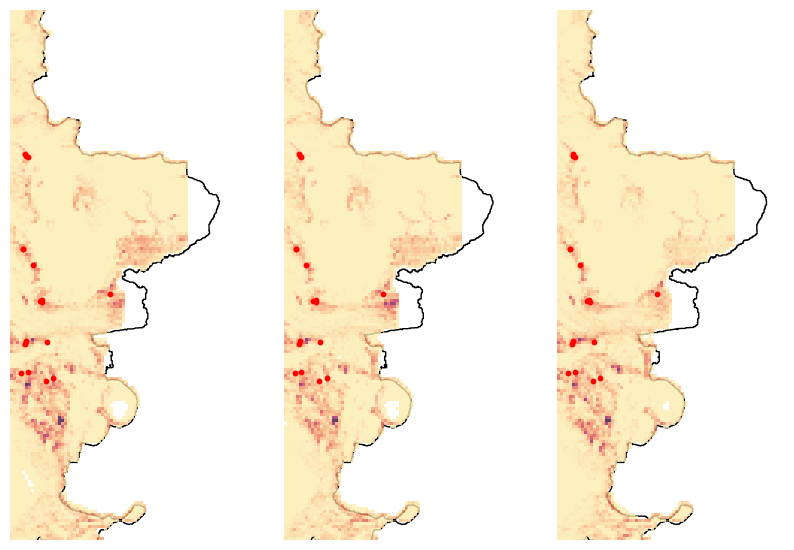

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(10, 20))
for i, (dmg, act) in enumerate(zip(dmg_outputs, active_outputs)):
    combined = dmg * act

    ax = axes.ravel()[i]

    rplt.show(
        combined, ax=ax, transform=active_transforms[i], cmap="cmo.matter", alpha=0.8
    )
    coastlines[i].exterior.plot(ax=ax, color="black", linewidth=1, zorder=-5)
    events.plot(ax=ax, color="red", markersize=10, zorder = 5)
    transform = active_transforms[i]
    ax.set_xlim(transform.c, transform.c + combined.shape[-1] * transform.a + 5e4)
    ax.set_ylim(
        transform.f + combined.shape[-2] * transform.e,
        transform.f,
    )
    ax.axis("off")
plt.show()

In [62]:
step_y = 2e3
step_x = 1e3
base_x_offset = 3 * step_x
events["x_offset"] = [
    base_x_offset,
    base_x_offset,
    base_x_offset,
    base_x_offset,
    base_x_offset,
    base_x_offset,
    base_x_offset,
    base_x_offset,
    -16 * step_x,
    2 * step_x,
    base_x_offset,
    -4 * step_x,
    -5 * step_x,
    base_x_offset,
    base_x_offset,
    base_x_offset,
    base_x_offset,
]
events["y_offset"] = [
    4 * step_y,
    1 * step_y,
    -2.5 * step_y,
    2 * step_y,
    -2 * step_y,
    0,
    0,
    2 * step_y,
    -2 * step_y,
    -3 * step_y,
    0,
    8 * step_y,
    -7 * step_y,
    0,
    0,
    -5 * step_y,
    -5 * step_y,
]

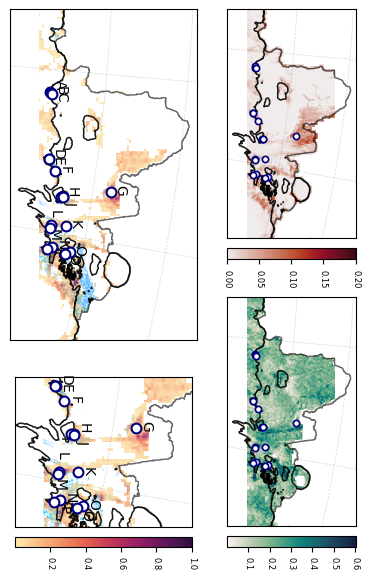

In [113]:
i_year = 1
year = years[i_year]
total_width = 15 / 2.54
dmg = dmg_outputs[i_year]
act = active_outputs[i_year]

xmin_z, xmax_z = 2.51e6, 2.70e6
ymax_z, ymin_z = -0.34e6, -0.50e6

fig, axes = plt.subplots(4, 2,
                        figsize=(10 / 2.54, total_width),
                        width_ratios=[1.2, 1],
                        height_ratios=[4, 1, 1, 4])

from mpl_toolkits.axes_grid1 import make_axes_locatable

"""Damage"""
gs = axes[0, 1].get_gridspec()
# remove the underlying axes
for ax in axes[:2, 1]:
    ax.remove()
ax_dmg = fig.add_subplot(gs[:2, 1])
fig_silent, ax_silent = plt.subplots()
dmg_silent = ax_silent.imshow(dmg[0], cmap="cmo.amp")
plt.close()

divider = make_axes_locatable(ax_dmg)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
cbar = fig.colorbar(dmg_silent, cax=cax, orientation="horizontal")
cbar.ax.tick_params(rotation=-90, labelsize=6)

rplt.show(dmg, ax=ax_dmg, transform=dmg_transforms[i_year], cmap="cmo.amp")

"""Activeness"""
gs = axes[2, 1].get_gridspec()
# remove the underlying axes
for ax in axes[2:, 1]:
    ax.remove()
ax_act = fig.add_subplot(gs[2:, 1])
# ax_act = axes[1, 1]
fig_silent, ax_silent = plt.subplots()
act_silent = ax_silent.imshow(act[0], cmap="cmo.tempo")
plt.close()

divider = make_axes_locatable(ax_act)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
cbar = fig.colorbar(act_silent, cax=cax, orientation="horizontal")
cbar.ax.tick_params(rotation=-90, labelsize=6)
cbar.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

rplt.show(act, ax=ax_act, transform=active_transforms[i_year], cmap="cmo.tempo")

for ax in [ax_dmg, ax_act]:
    events.plot(
        ax=ax,
        color="white",
        markersize=20,
        zorder=5,
        marker="o",
        edgecolor="navy",
        lw=1.2,
    )

combined = dmg * act
combined[dmg < 0.005] = np.nan
combined /= np.nanmax(combined)

"""Combined"""
gs = axes[0, 0].get_gridspec()
for ax in axes[:3, 0]:
    ax.remove()
ax_combined = fig.add_subplot(gs[:3, 0])

rplt.show(
    combined,
    ax=ax_combined,
    transform=active_transforms[i_year],
    cmap="cmo.matter",
    alpha=0.8,
)
events.plot(ax=ax_combined, color="white", markersize=50, zorder=5, marker="o", edgecolor = "navy", lw = 1.5)
for i, s in enumerate(events["label"].values):
    ax_combined.text(
        s=s,
        x=events["geometry"].x[i] + events.x_offset[i],
        y=events["geometry"].y[i] + events.y_offset[i],
        rotation=-90,
    )
lakes.plot(ax=ax_combined, color="deepskyblue", alpha=0.8, zorder=1)

"""Zoomed"""
ax_zoomed = axes[3, 0]
fig_silent, ax_silent = plt.subplots()
zoomed_silent = ax_silent.imshow(combined[0], cmap="cmo.matter")
plt.close()

divider = make_axes_locatable(ax_zoomed)
cax = divider.append_axes("bottom", size="7%", pad=0.1)
cbar = fig.colorbar(zoomed_silent, cax=cax, orientation="horizontal")
cbar.ax.tick_params(rotation=-90, labelsize=6)

rplt.show(
    combined,
    ax=ax_zoomed,
    transform=active_transforms[i_year],
    cmap="cmo.matter",
    alpha=0.8,
)
events_zoomed = gpd.GeoDataFrame(events.cx[xmin_z:xmax_z, ymin_z:ymax_z]).reset_index(drop=True)
lakes_zoomed = gpd.GeoDataFrame(lakes.cx[xmin_z:xmax_z, ymin_z:ymax_z]).reset_index(drop=True)
events_zoomed.plot(
    ax=ax_zoomed,
    color="white",
    markersize=50,
    zorder=5,
    marker="o",
    edgecolor="navy",
    lw=1.5,
)
lakes_zoomed.plot(ax=ax_zoomed, color="deepskyblue", alpha=0.8, zorder=1)
for i, s in enumerate(events_zoomed["label"].values):
    ax_zoomed.text(
        s=s,
        x=events_zoomed["geometry"].x[i] + events_zoomed.x_offset[i],
        y=events_zoomed["geometry"].y[i] + events_zoomed.y_offset[i],
        rotation=-90,
    )

"""Grid"""
grid_filtered = grid[grid["degrees"].isin([65, 66, 100, 95])]
for ax in [ax_dmg, ax_act, ax_combined, ax_zoomed]:
    grid_filtered.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.3, ls="--")
    coastlines[i_year].plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.6)
    grounding_line.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.1, alpha = 0.9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False,
    )
ax_zoomed.set_xlim(xmin_z, xmax_z)
ax_zoomed.set_ylim(ymin_z, ymax_z)

fig.tight_layout()
fig.savefig(os.path.join(figure_folder, "figure_02.pdf"), dpi=300, orientation="portrait", bbox_inches="tight")
plt.show()

In [64]:
def analyze_flow_field(vx_raster, vy_raster, resolution: float, pix: int = 1):
    dudx = (vx_raster - np.roll(vx_raster, pix, axis=0)) / resolution
    dvdy = (vy_raster - np.roll(vy_raster, pix, axis=1)) / resolution
    dudy = (vx_raster - np.roll(vx_raster, pix, axis=1)) / resolution
    dvdx = (vy_raster - np.roll(vy_raster, pix, axis=0)) / resolution
    exx = 0.5 * (dudx + dudx)
    eyy = 0.5 * (dvdy + dvdy)
    exy = 0.5 * (dudy + dvdx)
    emax = (exx + eyy) * 0.5 + np.sqrt(np.power(exx - eyy, 2) * 0.25 + np.power(exy, 2))

    emin = (exx + eyy) * 0.5 - np.sqrt(np.power(exx - eyy, 2) * 0.25 + np.power(exy, 2))
    return emax, emin


with rasterio.open(os.path.join(dmg_path, "30m_vx.tif")) as vx:
    vx_raster = vx.read(1)
    vx_transform = vx.transform

with rasterio.open(os.path.join(dmg_path, "30m_vy.tif")) as vy:
    vy_raster = vy.read(1)
    vy_transform = vy.transform

emax, emin = analyze_flow_field(vx_raster, vy_raster, 300)
strain = abs(emax) / np.nanmax(abs(emax))

In [ ]:
def get_value(raster: np.ndarray, transform: Affine, x: float,y: float):
    if raster.ndim == 2:
        count = 1
    elif raster.ndim > 3:
        raise ValueError("To High dimension of raster")
    else:
        count = raster.shape[0]
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=raster.shape[-2],
            width=raster.shape[-1],
            count=count,
            dtype=raster.dtype,
            transform=transform,
        ) as dataset:
            if count == 1 and raster.ndim == 2:
                dataset.write(raster, 1)
            else:
                for i in range(count):
                    dataset.write(raster[i], i + 1)
            row, col = dataset.index(x, y)
            return dataset.read(1)[row, col]

In [ ]:
combined0 = dmg_outputs[1].copy() * active_outputs[1].copy()
combined0 = combined0 / np.nanmax(combined0)
combined1 = np.power(dmg_outputs[1].copy(), 1/2 * active_outputs[1].copy())
combined1 = combined1 / np.nanmax(combined1)
combined2 = np.power(active_outputs[1].copy(), dmg_outputs[1].copy())
combined2 = combined2 / np.nanmax(combined2)

In [ ]:
lakes = gpd.read_file(r"D:\[Code]\HydrofractureShackleton_2023\data\L8S2_20201201_20210331_lakeextent.shp")
lakes.shape

(31544, 4)

In [ ]:
lake_active_values = []
lake_dmg_values = []
for i, lake in enumerate(lakes["geometry"]):
    lake_dmg_values.append(
        get_value(dmg_outputs[1], dmg_transforms[1], lake.centroid.x, lake.centroid.y)
    )
    lake_active_values.append(
        get_value(
            active_outputs[1], active_transforms[1], lake.centroid.x, lake.centroid.y
        )
    )

IndexError: index 176 is out of bounds for axis 0 with size 176

In [ ]:
active_values = []
dmg_values = []
combined0_values = []
combined1_values = []
combined2_values = []
strain_values = []
for i, geo in enumerate(events["geometry"]):
    combined0_values.append(get_value(combined0, transform, geo.x, geo.y))
    combined1_values.append(get_value(combined1, transform, geo.x, geo.y))
    combined2_values.append(get_value(combined2, transform, geo.x, geo.y))
    dmg_values.append(get_value(dmg_outputs[1], dmg_transforms[1], geo.x, geo.y))
    active_values.append(get_value(active_outputs[1], active_transforms[1], geo.x, geo.y))
    strain_values.append(get_value(strain, active_transforms[1], geo.x, geo.y))

In [ ]:
number_bins = 50
combined0_vs, combined0_xs = np.histogram(
    combined0[np.isfinite(combined0)], bins=number_bins
)
combined1_vs, combined1_xs = np.histogram(
    combined1[np.isfinite(combined1)], bins=number_bins
)
combined2_vs, combined2_xs = np.histogram(
    combined2[np.isfinite(combined2)], bins=number_bins
)
dmg_vs, dmg_xs = np.histogram(
    dmg_outputs[1][np.isfinite(dmg_outputs[1])] / np.nanmax(dmg_outputs[1]),
    bins=number_bins,
)
active_vs, active_xs = np.histogram(
    active_outputs[1][np.isfinite(active_outputs[1])] / np.nanmax(active_outputs[1]),
    bins=number_bins,
)
strain_vs, strain_xs = np.histogram(
    strain[np.isfinite(strain)],
    bins=number_bins,
)

fig, ax = plt.subplots()
ax.step(dmg_xs[:-1], dmg_vs, color="blue", alpha=0.5)
ax.step(combined0_xs[:-1], combined0_vs, color="lightcoral", alpha=0.7)
ax.step(combined1_xs[:-1], combined1_vs, color="red", alpha=0.5)
ax.step(combined2_xs[:-1], combined2_vs, color="darkred", alpha=0.5)
ax.step(active_xs[:-1], active_vs, color="olive", alpha=0.5)
ax.step(strain_xs[:-1], strain_vs, color="darkorange", alpha=0.5)
ax.set_yscale("log")

for i, geo in enumerate(events["geometry"]):
    if i == 0:
        label_dmg = "dmg"
        label_combined0 = "dmg * active"
        label_combined1 = "dmg^active"
        label_combined2 = "active^dmg"
        label_active = "active"
        label_strain = "strain"
    else:
        label_dmg = None
        label_combined0 = None
        label_combined1 = None
        label_combined2 = None
        label_active = None
        label_strain = None
    x_dmg = dmg_values[i]
    ax.scatter(
        x=x_dmg,
        y=dmg_vs[dmg_xs[:-1] > x_dmg][0],
        color="navy",
        label=label_dmg,
    )

    x_active = active_values[i]
    ax.scatter(x=x_active, y=active_vs[active_xs[:-1] > x_active][0], color="olive", label = label_active)

    x_combined0 = combined0_values[i]
    ax.scatter(
        x=x_combined0,
        y=combined0_vs[combined0_xs[:-1] > x_combined0][0],
        color="lightcoral",
        label=label_combined0,
    )
    

    x_combined1 = combined1_values[i]
    ax.scatter(
        x=x_combined1,
        y=combined1_vs[combined1_xs[:-1] > x_combined1][0],
        color="red",
        label=label_combined1,
    )
    try:
        x_combined2 = combined2_values[i]
        ax.scatter(
            x=x_combined2,
            y=combined2_vs[combined2_xs[:-1] > x_combined2][0],
            color="darkred",
            label=label_combined2,
        )
    except:
        pass
    x_strain = strain_values[i]
    ax.scatter(
        x=x_strain,
        y=strain_vs[strain_xs[:-1] > x_strain][0],
        color="darkorange",
        label=label_strain,
    )
# ax.set_xscale("log")
ax.legend()
plt.show()